<a href="https://colab.research.google.com/github/timthlaw/Deeplearning.ai-Natural-Language-Processing-Specialization/blob/master/Challenge(functions).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Challenge

## Download and install Spark

In [2]:
!ls

sample_data


In [3]:
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-2.3.1/spark-2.3.1-bin-hadoop2.7.tgz
!tar xf spark-2.3.1-bin-hadoop2.7.tgz
!pip install -q findspark

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:10 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [56.8 kB]
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:13 http://ppa.launchpad.net/cran/

## Setup environment

In [4]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.3.1-bin-hadoop2.7"

import findspark
findspark.init()
from pyspark import SparkContext
sc = SparkContext.getOrCreate()

import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate() 
spark

## Downloading and preprocessing Chicago's Reported Crime Data

In [5]:
#!wget https://data.cityofchicago.org/api/views/ijzp-q8t2/rows.csv?accessType=DOWNLOAD
#!ls -l

In [6]:
#!mv rows.csv\?accessType\=DOWNLOAD reported-crimes.csv
#!ls -l

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
from pyspark.sql.functions import to_timestamp,col,lit
rc = spark.read.csv('/content/drive/My\ Drive/reported-crimes.csv',header=True).withColumn('Date',to_timestamp(col('Date'),'MM/dd/yyyy hh:mm:ss a')).filter(col('Date') <= lit('2018-11-11 23:59:59'))
rc.show(5)

+--------+-----------+-------------------+--------------------+----+------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|      ID|Case Number|               Date|               Block|IUCR|Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|
+--------+-----------+-------------------+--------------------+----+------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|10224738|   HY411648|2015-09-05 13:30:00|     043XX S WOOD ST|0486|     BATTERY|DOMESTIC BATTERY ...|           RESIDENCE| false|    true|0924|     00

## Challenge questions

**What is the most frequently reported non-criminal activity?**

In [9]:
rc.cache()
rc.count()

6754931

In [17]:
rc.select(col("Primary Type")).distinct().orderBy(col("Primary Type")).show(30, truncate=False)

+---------------------------------+
|Primary Type                     |
+---------------------------------+
|ARSON                            |
|ASSAULT                          |
|BATTERY                          |
|BURGLARY                         |
|CONCEALED CARRY LICENSE VIOLATION|
|CRIM SEXUAL ASSAULT              |
|CRIMINAL DAMAGE                  |
|CRIMINAL SEXUAL ASSAULT          |
|CRIMINAL TRESPASS                |
|DECEPTIVE PRACTICE               |
|DOMESTIC VIOLENCE                |
|GAMBLING                         |
|HOMICIDE                         |
|HUMAN TRAFFICKING                |
|INTERFERENCE WITH PUBLIC OFFICER |
|INTIMIDATION                     |
|KIDNAPPING                       |
|LIQUOR LAW VIOLATION             |
|MOTOR VEHICLE THEFT              |
|NARCOTICS                        |
|NON - CRIMINAL                   |
|NON-CRIMINAL                     |
|NON-CRIMINAL (SUBJECT SPECIFIED) |
|OBSCENITY                        |
|OFFENSE INVOLVING CHILDREN 

In [21]:
rc.filter(col("Primary Type").isin(['NON - CRIMINAL', 'NON-CRIMINAL', 'NON-CRIMINAL (SUBJECT SPECIFIED)'])).groupBy(col("Description")).count().orderBy("count", ascending=False).show()

+--------------------+-----+
|         Description|count|
+--------------------+-----+
|       LOST PASSPORT|  107|
|   FOID - REVOCATION|   75|
|NOTIFICATION OF C...|    9|
|NOTIFICATION OF S...|    8|
|      FOUND PASSPORT|    4|
|CONCEALED CARRY L...|    4|
|GUN OFFENDER NOTI...|    3|
+--------------------+-----+



In [30]:
%%time
rc.createOrReplaceTempView("rc")


spark.sql(
    """
    SELECT Description,
           COUNT(Description) AS count
    FROM rc
    WHERE `Primary Type` IN ('NON - CRIMINAL', 'NON-CRIMINAL', 'NON-CRIMINAL (SUBJECT SPECIFIED)')
    GROUP BY Description
    ORDER BY count DESC
    """
).show(30, truncate=False)

spark.catalog.dropTempView("rc")

+-------------------------------------------+-----+
|Description                                |count|
+-------------------------------------------+-----+
|LOST PASSPORT                              |107  |
|FOID - REVOCATION                          |75   |
|NOTIFICATION OF CIVIL NO CONTACT ORDER     |9    |
|NOTIFICATION OF STALKING - NO CONTACT ORDER|8    |
|CONCEALED CARRY LICENSE REVOCATION         |4    |
|FOUND PASSPORT                             |4    |
|GUN OFFENDER NOTIFICATION-NO CONTACT       |3    |
+-------------------------------------------+-----+

CPU times: user 226 ms, sys: 17.4 ms, total: 243 ms
Wall time: 51.7 s


**Using a bar chart, plot which day of the week has the most number of reported crime. 
**

In [45]:
import pyspark.sql.functions as F

rc.select(F.dayofweek(col('Date')), F.date_format(col('Date'), 'E')).show()

+---------------+--------------------+
|dayofweek(Date)|date_format(Date, E)|
+---------------+--------------------+
|              7|                 Sat|
|              6|                 Fri|
|              7|                 Sat|
|              7|                 Sat|
|              7|                 Sat|
|              7|                 Sat|
|              6|                 Fri|
|              7|                 Sat|
|              7|                 Sat|
|              1|                 Sun|
|              7|                 Sat|
|              7|                 Sat|
|              7|                 Sat|
|              7|                 Sat|
|              5|                 Thu|
|              7|                 Sat|
|              7|                 Sat|
|              4|                 Wed|
|              7|                 Sat|
|              7|                 Sat|
+---------------+--------------------+
only showing top 20 rows



In [46]:
rc.groupBy(F.date_format(col('Date'), 'E')).count().orderBy("count", ascending=False).show()

+--------------------+-------+
|date_format(Date, E)|  count|
+--------------------+-------+
|                 Fri|1017113|
|                 Wed| 974030|
|                 Tue| 968170|
|                 Sat| 965308|
|                 Thu| 964708|
|                 Mon| 952867|
|                 Sun| 912735|
+--------------------+-------+



In [50]:
DoW = [x[0] for x in rc.groupBy(F.date_format(col('Date'), 'E')).count().collect()]
DoW

['Sun', 'Mon', 'Thu', 'Sat', 'Wed', 'Fri', 'Tue']

In [49]:
cnt = [x[1] for x in rc.groupBy(F.date_format(col('Date'), 'E')).count().collect()]
cnt

[912735, 952867, 964708, 965308, 974030, 1017113, 968170]

Text(0.5, 1.0, 'Number of reported crimes')

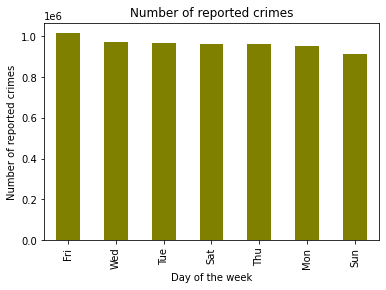

In [65]:
import matplotlib.pyplot as plt
import pandas as pd

cp = pd.DataFrame({'DayOfWeek': DoW, 'Count': cnt})
fig, ax = plt.subplots()
cp.sort_values('Count', ascending=False).plot(kind='bar', x='DayOfWeek', y='Count', color='olive', legend=False, ax=ax)
ax.set_xlabel('Day of the week')
ax.set_ylabel('Number of reported crimes')
ax.set_title('Number of reported crimes')
